# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS-109A Introduction to Data Science 


## Predicting Particulate Pollution in the United States

**Harvard University**<br>
**Spring 2020**<br>
Jack Luby, Hakeem Angulu, and Louie Ayre <br>

---



### The Problem

Fine particulate matter (PM$_{2.5}$) is an air pollutant which has been shown to increase the risk of mortality and hospitalization in exposed populations. The fine inhalable particles of PM$_{2.5}$ impact communitites at the local level, incrementally decreasing their life expectancies as ambient concentrations of the pollutant rise. Despite their adverse effects, concentrations of PM$_{2.5}$ are not well monitored throughout much of the United States (especially in regions of low population density). As a result, many communities (and their care providers) are unaware of the life-shortening ambient concentrations of PM$_{2.5}$ they breathe each day. In order to better serve these communities, improve health outcomes, and inform decision-making, we must use the instruments at our disposal to better understand and address the risks posed by PM$_{2.5}$ pollution.

### Our Project

This problem can be tackled using novel machine learning techniques. In training deep learning models on explicitly monitored PM$_{2.5}$ levels, along with satellite-based aerosol optical depth (AOD) measures, land-use metrics, and other key indicators, researchers have had success modelling PM$_{2.5}$ concentrations in the United States. In this project we will attempt to build upon these models, with a particular focus on understanding dangerous PM$_{2.5}$ concentrations in the most under-monitored populations of the US.

In [14]:
## Set formatting to CS109 standard
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [12]:
# The classics
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
aa = pd.read_csv('data/airpred_assembled.csv')
ac = pd.read_csv('data/airpred_clean.csv')

In [4]:
print('airpred_assmebled dims:', aa.shape)
print('airpred_clean dims:', ac.shape)

airpred_assmebled dims: (21560, 116)
airpred_clean dims: (21560, 116)


In [5]:
# The difference between these two datasets appears to be that the variables in the clean set have
# been normalized to (0,1). Weirdly, many of the variables appear to have min and max values near 
# but not equal to 0 or 1.

ac.describe()

site     year  MonitorData  GFEDFireCarbon  \
count  21560.000000  21560.0  5361.000000    21560.000000   
mean    1078.500000   2012.0     0.425611        0.001330   
std      622.397957      0.0     0.124394        0.020375   
min        1.000000   2012.0     0.000000        0.000000   
25%      539.750000   2012.0     0.356651        0.000000   
50%     1078.500000   2012.0     0.436703        0.000000   
75%     1617.250000   2012.0     0.502633        0.000000   
max     2156.000000   2012.0     0.863512        0.918922   

       USElevation_dsc10000  USElevation_max100  USElevation_max10000  \
count          21540.000000        21540.000000          21540.000000   
mean               0.141622            0.135007              0.141626   
std                0.170930            0.165402              0.169422   
min                0.000000            0.000000              0.000000   
25%                0.032709            0.030751              0.033583   
50%                0.077938            0.072962              0.078787   
75%                0.140784            0.132869              0.140798   
max                1.000000            1.000000              1.000000   

       USElevation_mea100  USElevation_mea10000  USElevation_med100  ...  \
count        21520.000000          21540.000000        21530.000000  ...   
mean             0.134627              0.141842            0.134499  ...   
std              0.166339              0.170903            0.166247  ...   
min              0.000000              0.000000            0.000000  ...   
25%              0.029842              0.032965            0.029825  ...   
50%              0.071679              0.078193            0.071637  ...   
75%              0.132314              0.141047            0.132164  ...   
max              1.000000              1.000000            1.000000  ...   

       Nearby_Peak2Lag3_MeanTemperature  Nearby_Peak2Lag3_MinTemperature  \
count                      21560.000000                     21560.000000   
mean                           0.526702                         0.548137   
std                            0.116806                         0.111665   
min                            0.075414                         0.000000   
25%                            0.448482                         0.488600   
50%                            0.530919                         0.563008   
75%                            0.598456                         0.616786   
max                            0.990877                         0.968555   

       OMAEROe_UVAerosolIndex_Mean  OMAEROe_VISAerosolIndex_Mean  \
count                 21560.000000                  21560.000000   
mean                      0.483195                      0.482956   
std                       0.116774                      0.129439   
min                       0.082772                      0.036852   
25%                       0.415303                      0.390289   
50%                       0.482194                      0.469571   
75%                       0.546198                      0.575082   
max                       1.000000                      0.930430   

       OMAERUVd_UVAerosolIndex_Mean  \
count                  21560.000000   
mean                       0.251480   
std                        0.127802   
min                        0.001917   
25%                        0.165918   
50%                        0.234521   
75%                        0.312021   
max                        1.000000   

       OMNO2d_ColumnAmountNO2StratoCloudScreened_Mean        OMO3PR  \
count                                    21560.000000  21560.000000   
mean                                         0.384467      0.609950   
std                                          0.327142      0.102732   
min                                          0.000000      0.046508   
25%                                          0.000000      0.539325   
50%                                          0

In [6]:
# Also of note: REANALYSIS_windspeed_10m_1Day only contains NaN values.

aa['REANALYSIS_windspeed_10m_1Day'].unique()

array([nan])

In [7]:
# Because of this weirdness and the fact that I don't know how they normalized it (whether they
# just squashed it between 0 and 1) I'd rather do it myself. I may have to give more thought
# to which scaler I use, though.
# For now I'm opting for RobustScaler() based on results demonstrated here:
# https://towardsdatascience.com/normalization-vs-standardization-quantitative-analysis-a91e8a79cebf
aa_c = aa.copy()

aa_c.iloc[:,3:] = preprocessing.RobustScaler().fit_transform(aa_c.iloc[:,3:])

/Users/hakeemangulu/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:995: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/Users/hakeemangulu/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1372: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


In [8]:
# We can look at our new cleaned values.

aa_c.describe()

site     year  MonitorData  GFEDFireCarbon  \
count  21560.000000  21560.0  5361.000000    21560.000000   
mean    1078.500000   2012.0     0.265167        0.059104   
std      622.397957      0.0     1.157351        0.905217   
min        1.000000   2012.0    -0.989095        0.000000   
25%      539.750000   2012.0    -0.432160        0.000000   
50%     1078.500000   2012.0     0.000000        0.000000   
75%     1617.250000   2012.0     0.567840        0.000000   
max     2156.000000   2012.0    11.974563       40.825930   

       USElevation_dsc10000  USElevation_max100  USElevation_max10000  \
count          21540.000000        21540.000000          21540.000000   
mean               0.589245            0.607579              0.586099   
std                1.581580            1.619717              1.580196   
min               -0.721147           -0.714489             -0.734847   
25%               -0.418502           -0.413352             -0.421623   
50%                0.000000            0.000000              0.000000   
75%                0.581498            0.586648              0.578377   
max                8.531623            9.078125              8.592135   

       USElevation_mea100  USElevation_mea10000  USElevation_med100  ...  \
count        21520.000000          21540.000000        21530.000000  ...   
mean             0.614292              0.588904            0.614251  ...   
std              1.623261              1.581236            1.624469  ...   
min             -0.699500             -0.723457           -0.700000  ...   
25%             -0.408280             -0.418452           -0.408571  ...   
50%              0.000000              0.000000            0.000000  ...   
75%              0.591720              0.581548            0.591429  ...   
max              9.059243              8.528798            9.071429  ...   

       Nearby_Peak2Lag3_MeanTemperature  Nearby_Peak2Lag3_MinTemperature  \
count                      21560.000000                     2.156000e+04   
mean                          -0.035688                    -4.826146e-02   
std                            0.730776                     7.841405e-01   
min                           -2.362308                    -2.280497e+00   
25%                           -0.553160                    -5.592148e-01   
50%                            0.000000                    -3.763487e-15   
75%                            0.446840                     4.407852e-01   
max                            2.186331                     3.016141e+00   

       OMAEROe_UVAerosolIndex_Mean  OMAEROe_VISAerosolIndex_Mean  \
count                 16791.000000                  16791.000000   
mean                      0.023240                      0.061694   
std                       0.715507                      0.666676   
min                      -2.160105                     -2.104202   
25%                      -0.503937                     -0.421351   
50%                       0.000000                      0.000000   
75%                       0.496063                      0.578649   
max                       2.842520                      2.253833   

       OMAERUVd_UVAerosolIndex_Mean  \
count                  17706.000000   
mean                       0.146079   
std                        0.839295   
min                       -1.352406   
25%                       -0.436908   
50%                        0.000000   
75%                        0.563092   
max                        4.685752   

       OMNO2d_ColumnAmountNO2StratoCloudScreened_Mean        OMO3PR  \
count                                    2.156000e+04  2.112000e+04   
mean                                    -2.321308e-01  1.705618e-02   
std                                      4.973306e-01  7.182641e-01   
min                                     -8.166076e-01 -3.959612e+00   
25%                                     -8.166076e-01 -4.776441e-01   
50%                                     -3.307

In [9]:
# As of our now, our sample data only contains a 10 day span in January of 2012
# Biggest step going forward will be to aggregate more data

print("Min date:", aa_c['date'].min(), "Max date:", aa_c['date'].max())

Min date: 2012-01-01 Max date: 2012-01-10


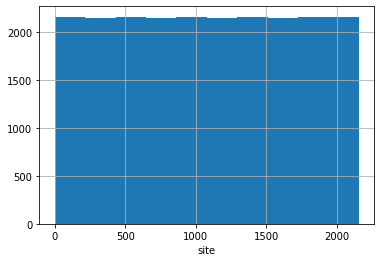

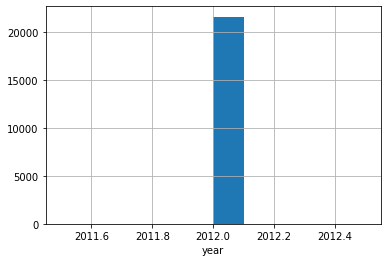

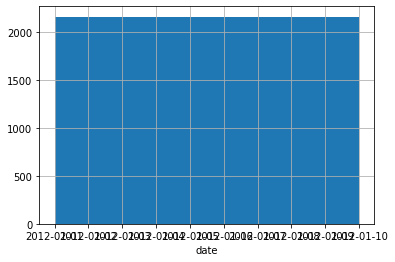

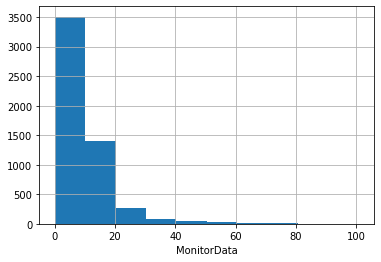

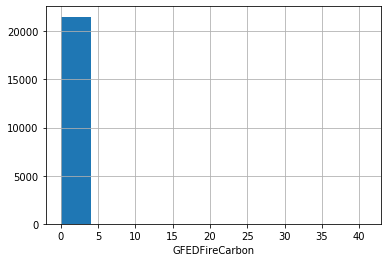

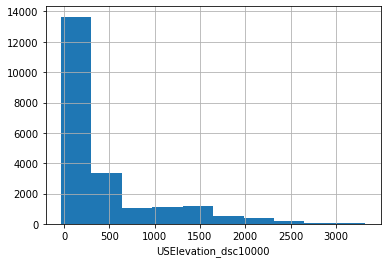

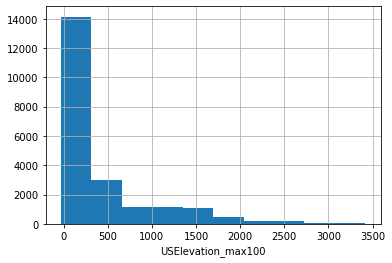

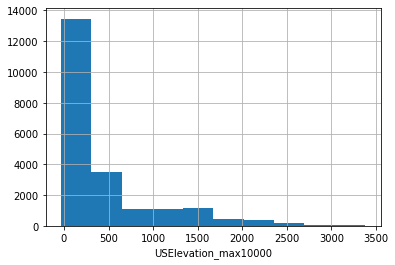

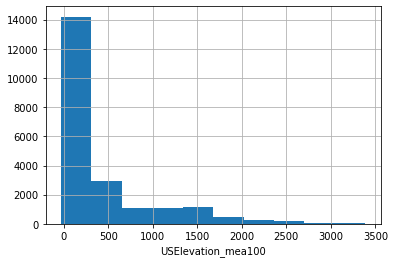

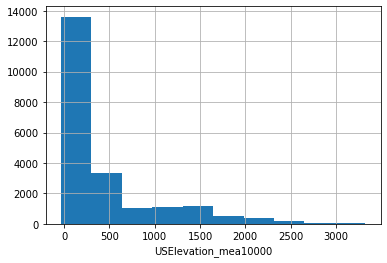

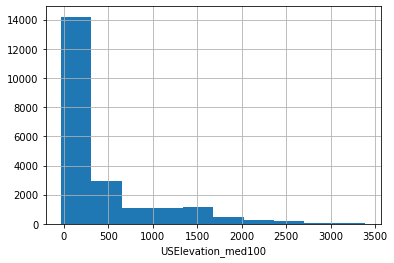

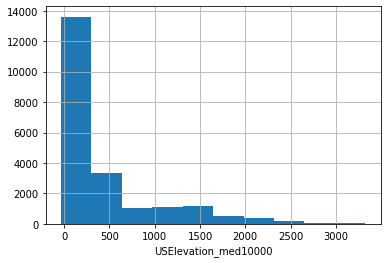

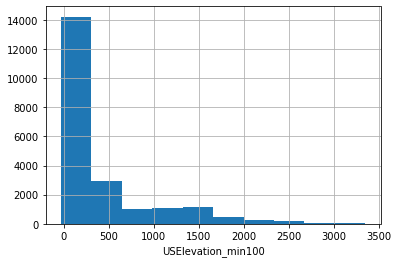

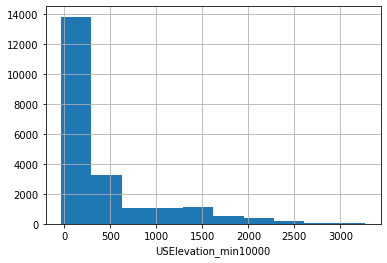

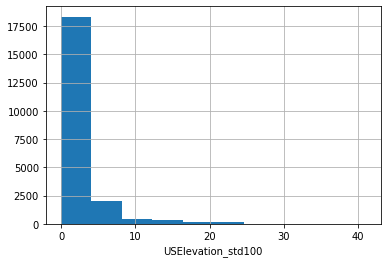

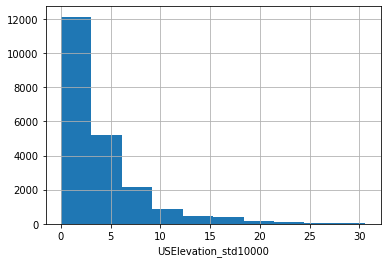

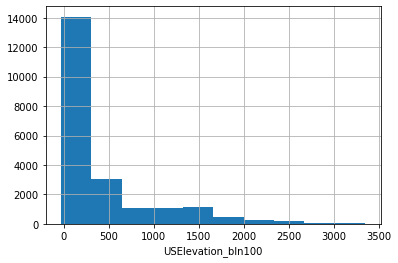

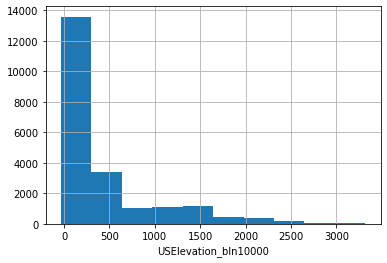

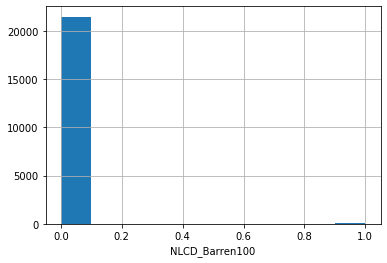

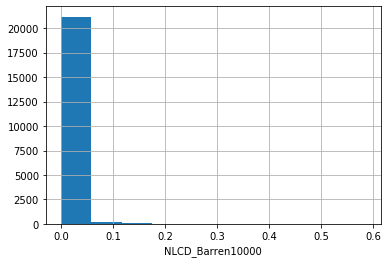

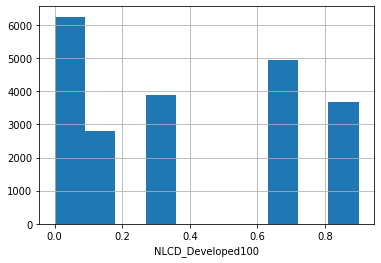

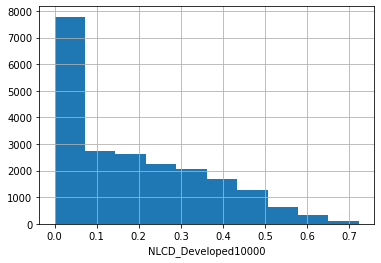

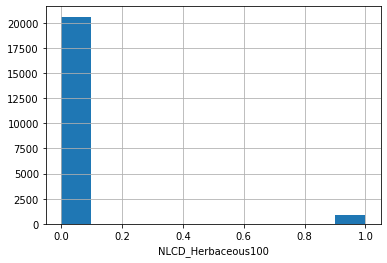

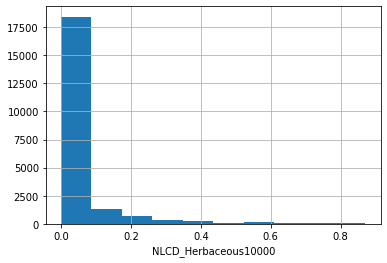

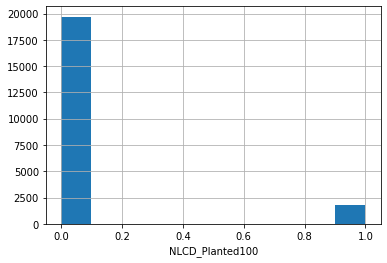

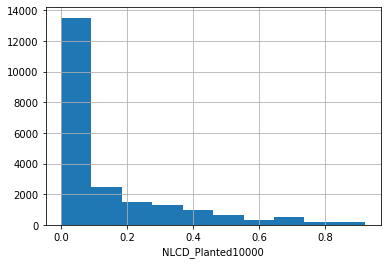

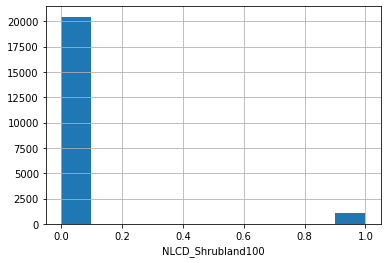

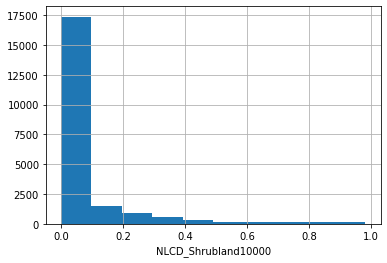

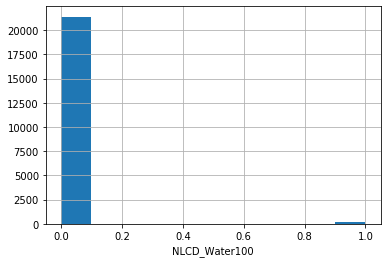

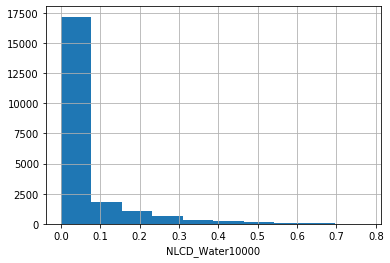

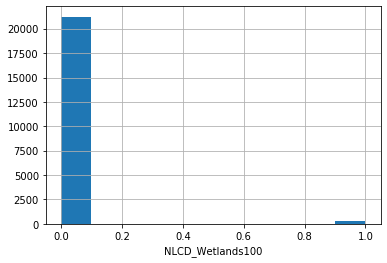

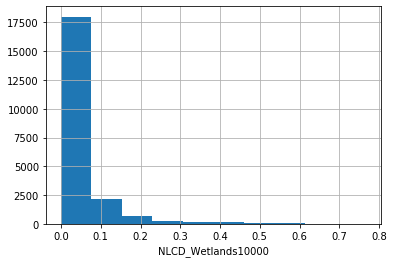

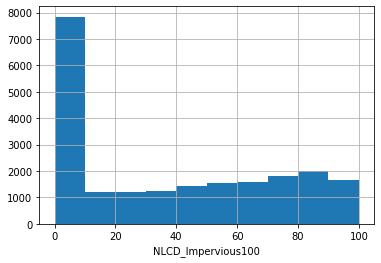

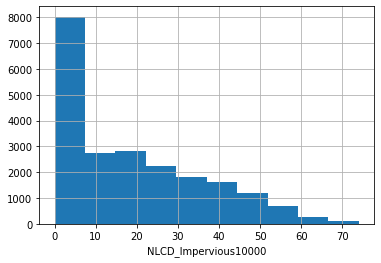

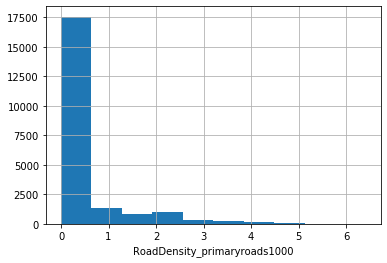

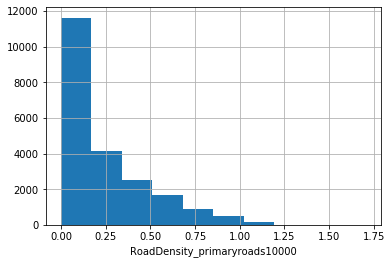

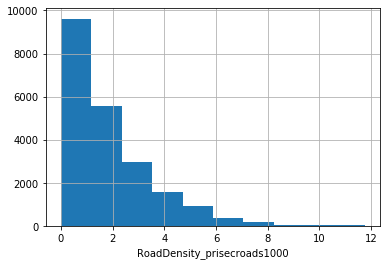

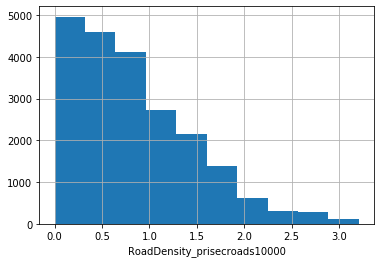

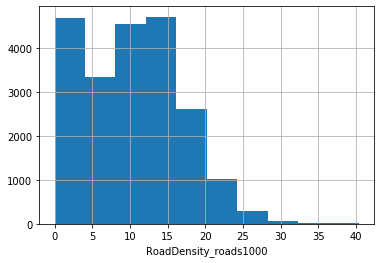

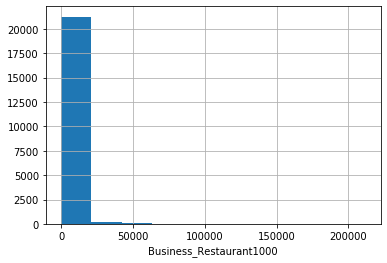

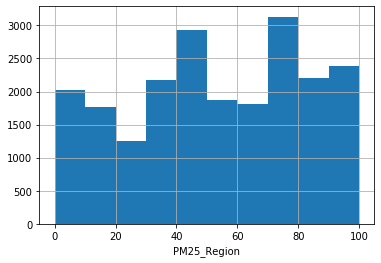

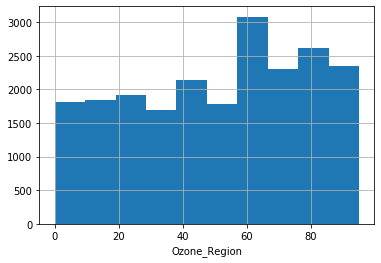

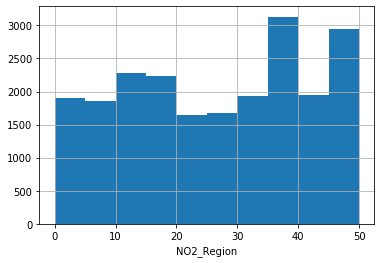

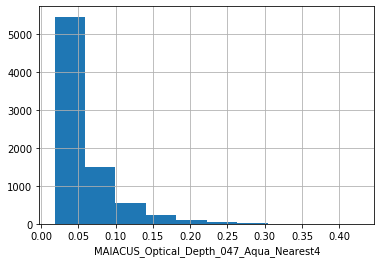

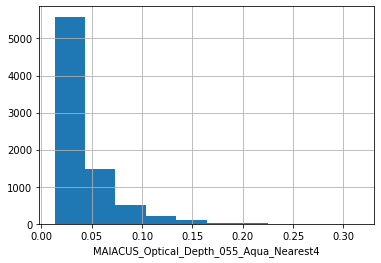

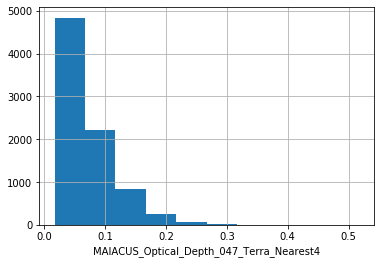

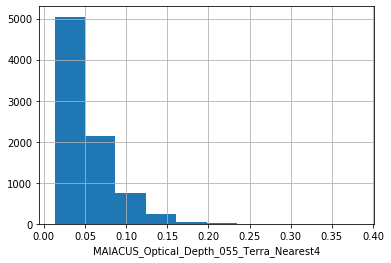

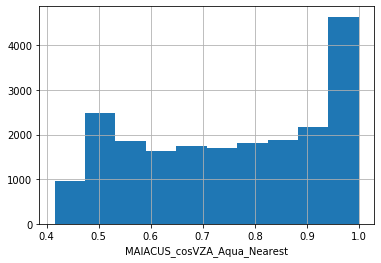

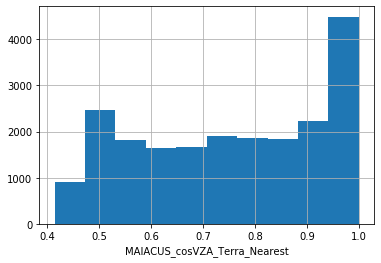

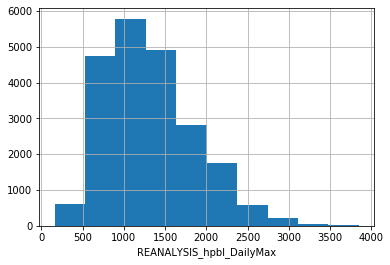

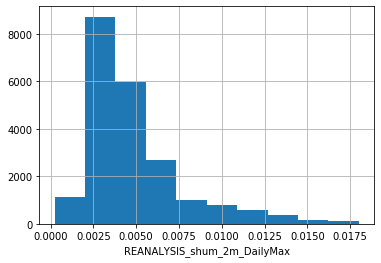

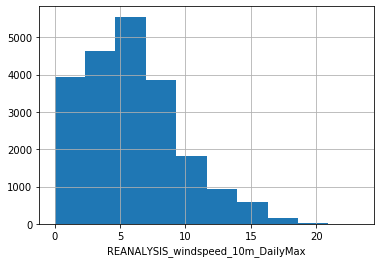

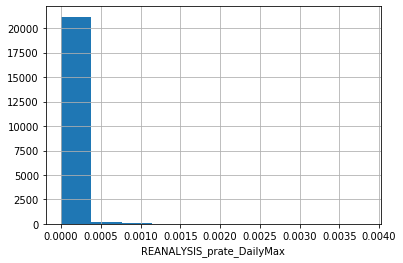

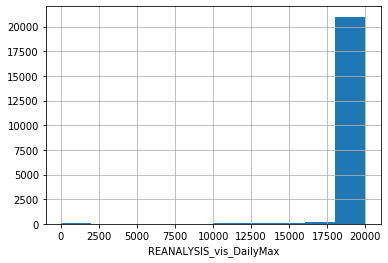

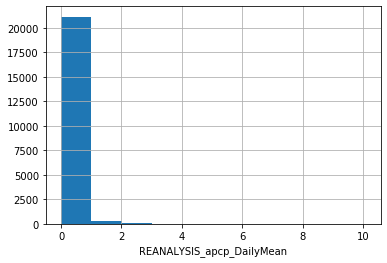

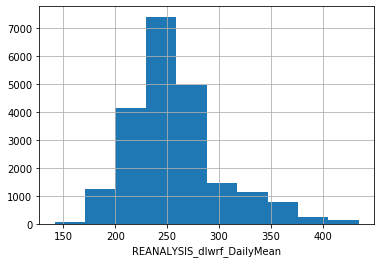

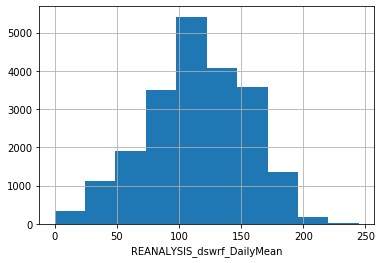

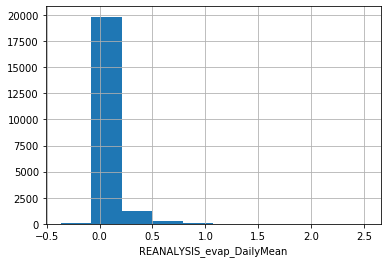

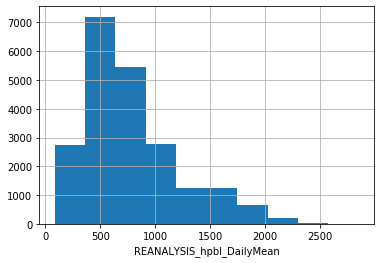

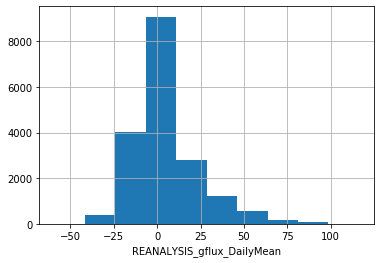

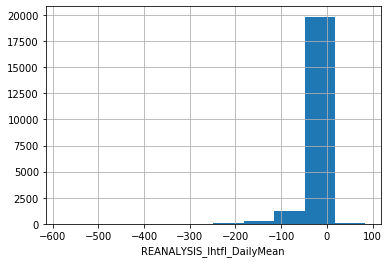

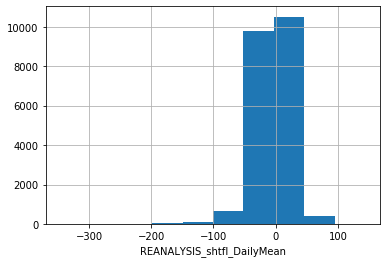

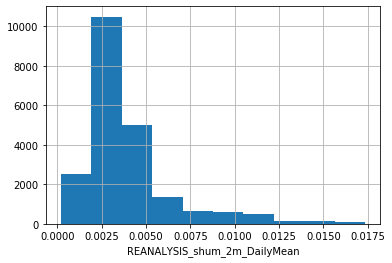

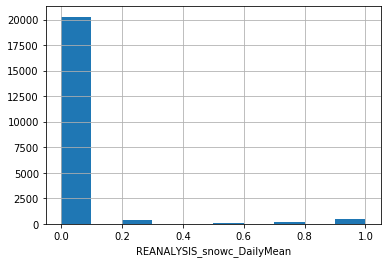

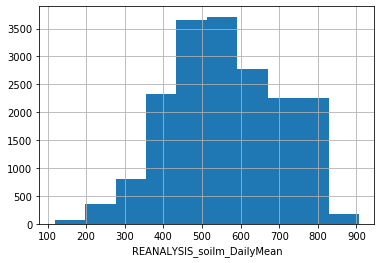

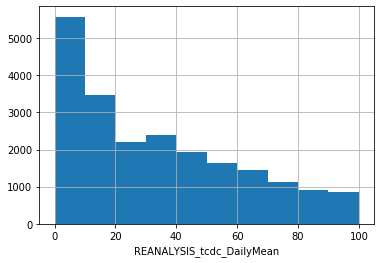

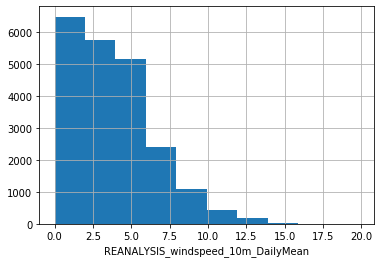

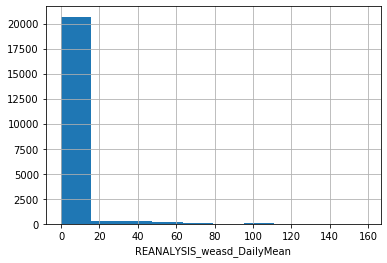

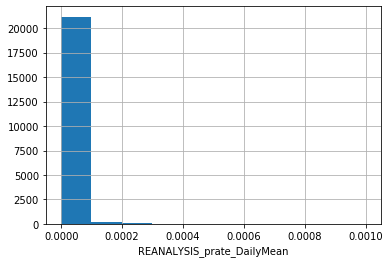

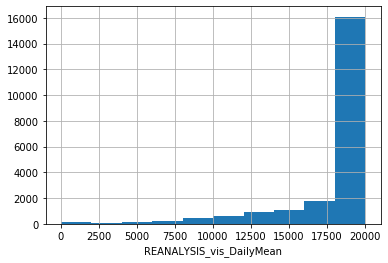

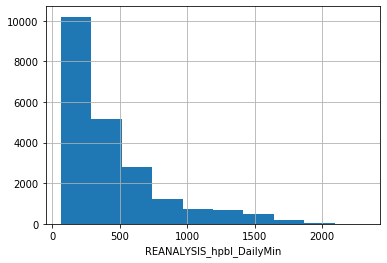

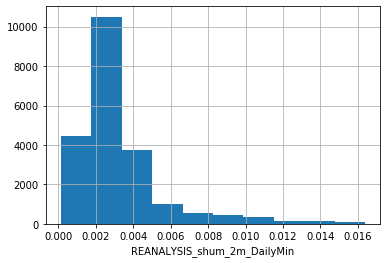

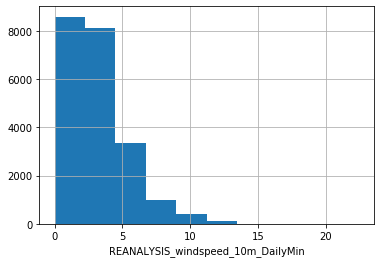

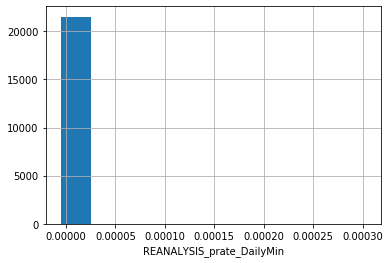

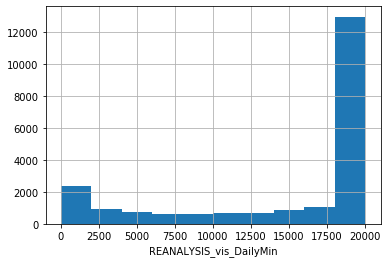

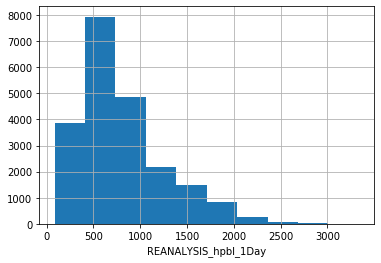

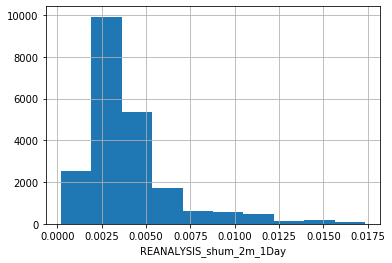

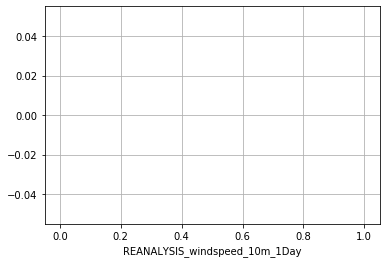

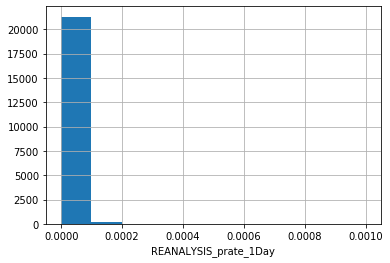

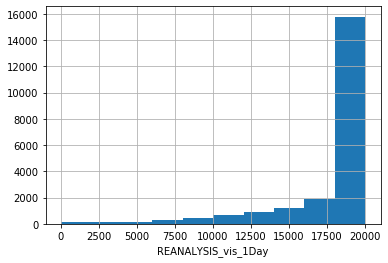

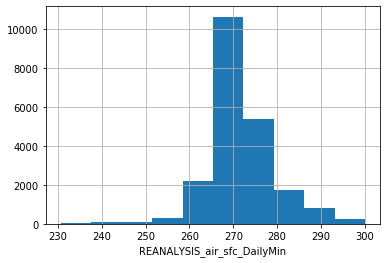

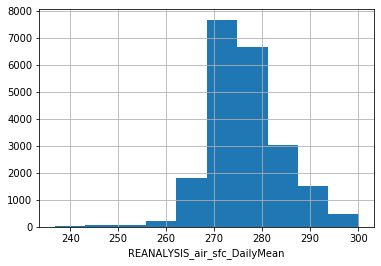

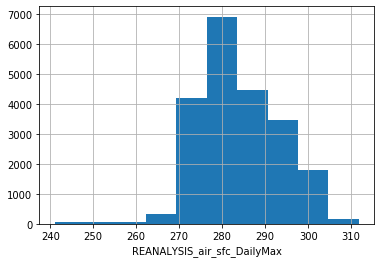

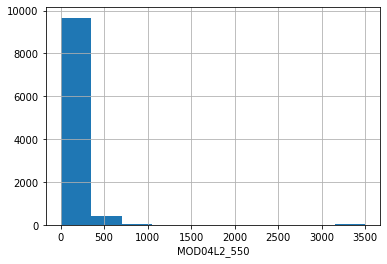

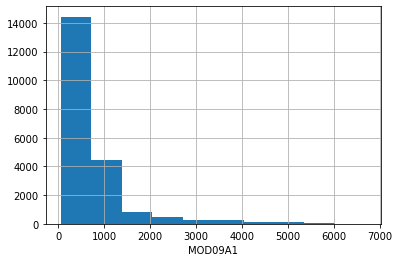

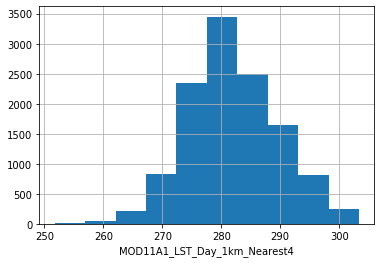

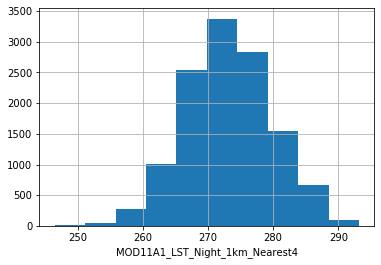

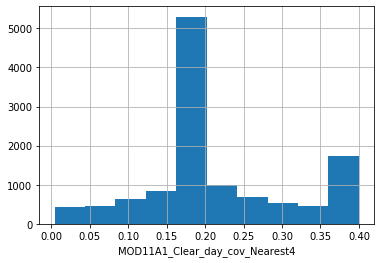

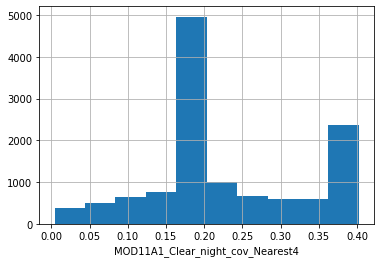

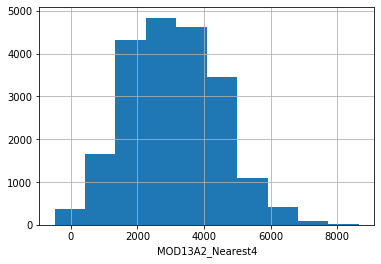

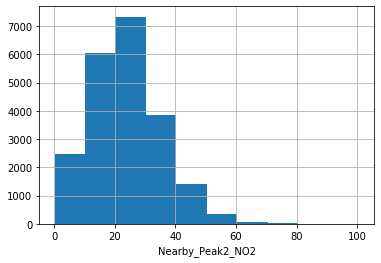

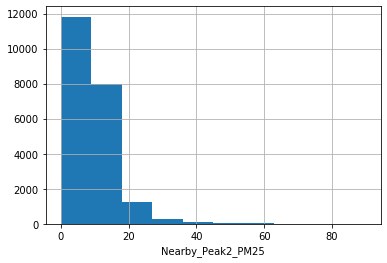

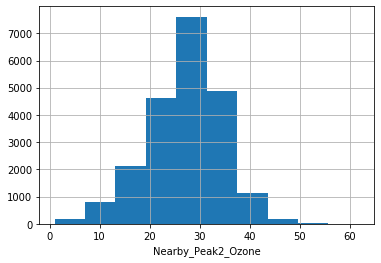

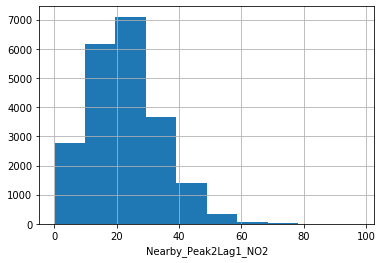

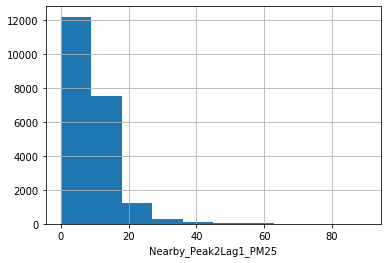

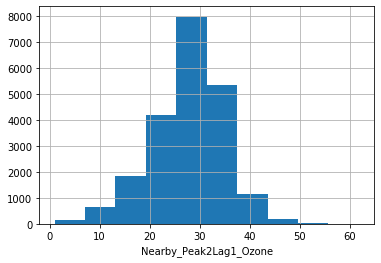

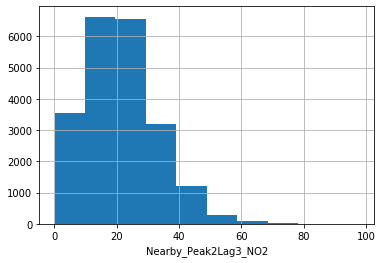

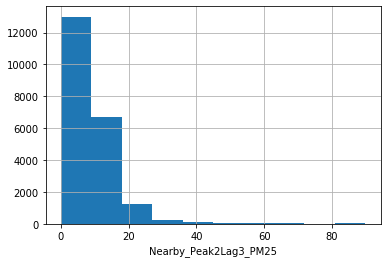

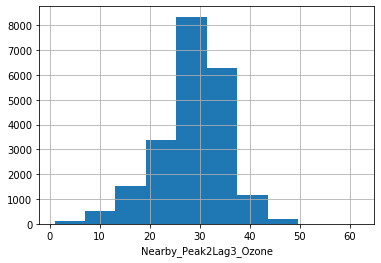

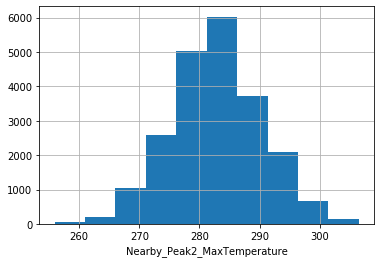

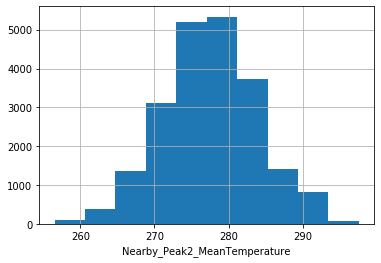

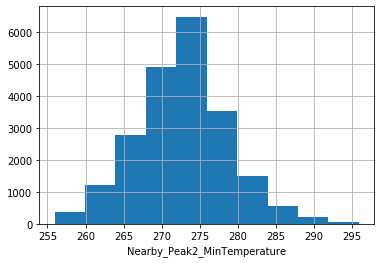

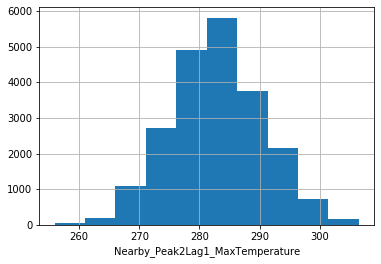

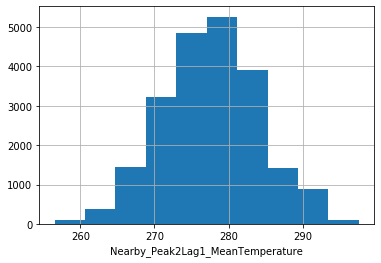

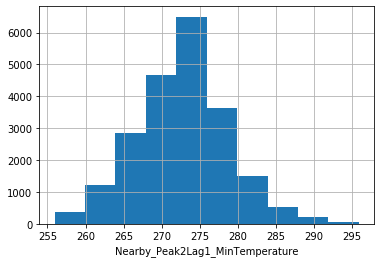

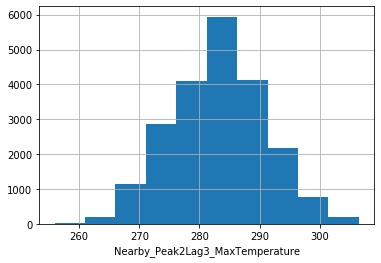

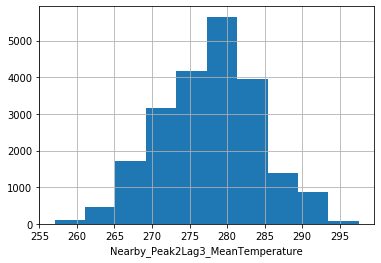

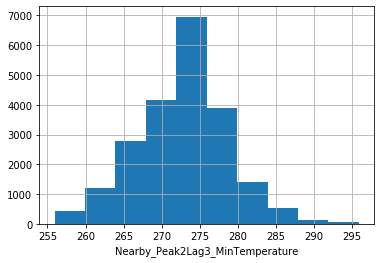

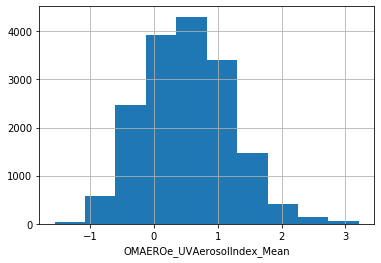

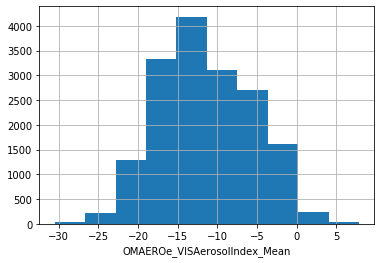

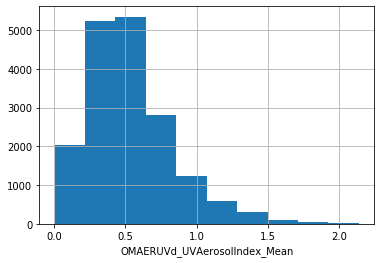

IndexError: index -9223372036854775808 is out of bounds for axis 0 with size 11

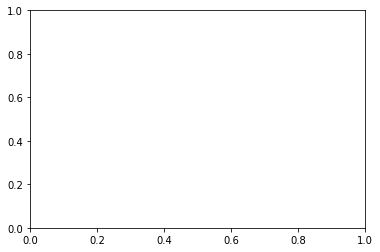

In [223]:
# Scrolling to get an idea of the distribution of our data pre-normalization (to get a better idea of magnitudes)

for col in aa.columns:
    aa[str(col)].hist()
    plt.xlabel(str(col))
    plt.show();

In [15]:
aa_c.to_csv("data/airpred.csv", index=False)

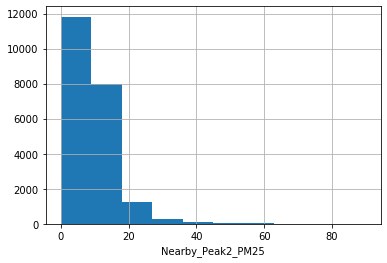

Min PM25: 0.0042 Max PM25: 89.8196


In [234]:
# We note wide variation in PM25 levels
aa['Nearby_Peak2_PM25'].hist()
plt.xlabel('Nearby_Peak2_PM25')
plt.show();
print("Min PM25:", round(aa['Nearby_Peak2_PM25'].min(), 4), "Max PM25:", round(aa['Nearby_Peak2_PM25'].max(),4))

In [221]:
# for each of these sites we'd like to predict Nearby_Peak2_PM25 using our other variables (with a 
# categorical labelling for site)

response = 'Nearby_Peak2_PM25'

X_train, X_test, y_train, y_test = train_test_split(aa_c.loc[:, aa_c.columns != response], 
                                                         aa_c[response], test_size=0.2, 
                                                         random_state = 109)

# Remove lagged variables since we're focused on predicting regions without PM data
X_train = X_train[X_train.columns.drop(['Nearby_Peak2Lag1_PM25', 'Nearby_Peak2Lag3_PM25', 'site', 'year', 'date'])]
X_test = X_test[X_test.columns.drop(['Nearby_Peak2Lag1_PM25', 'Nearby_Peak2Lag3_PM25', 'site', 'year', 'date'])]

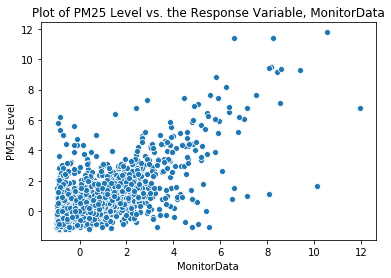

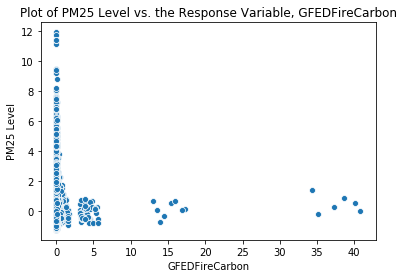

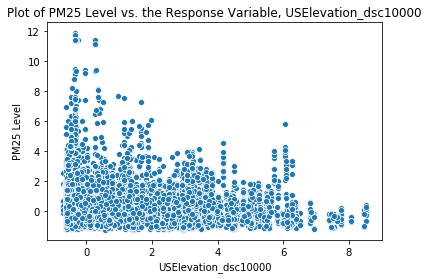

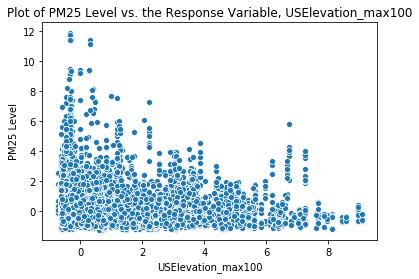

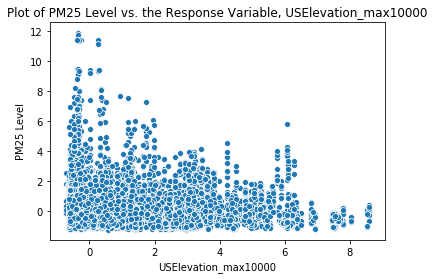

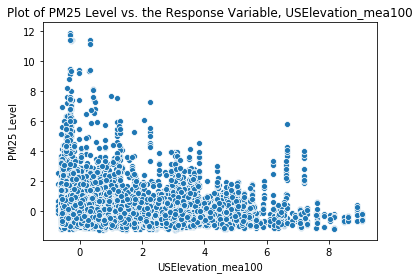

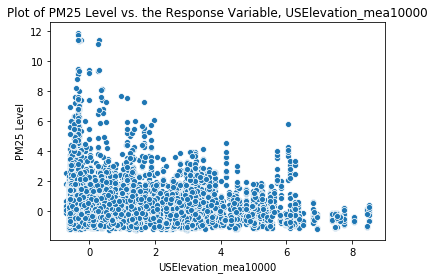

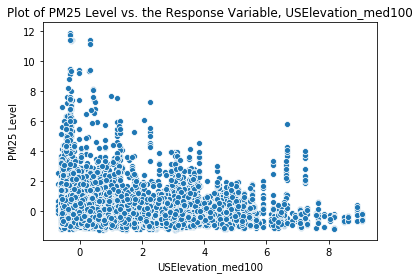

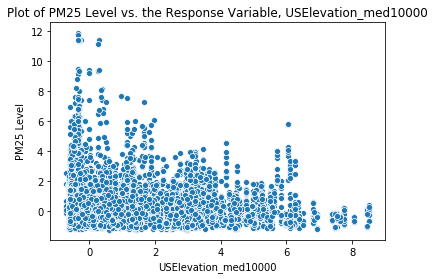

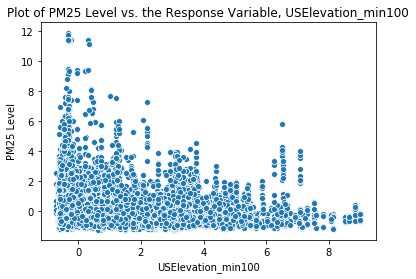

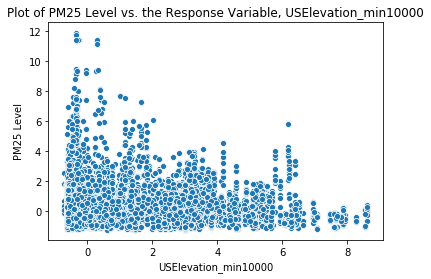

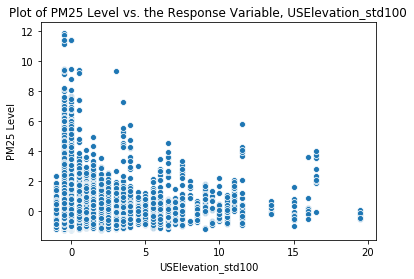

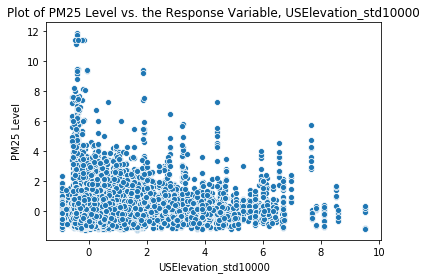

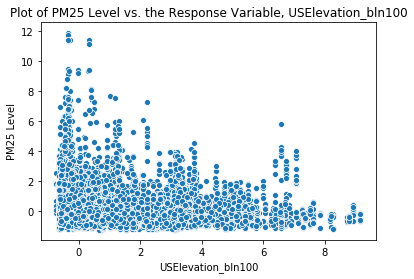

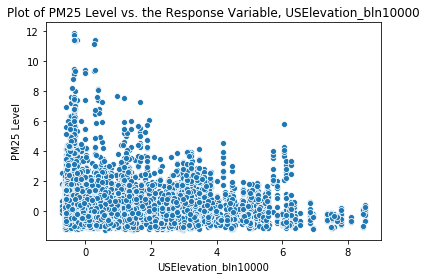

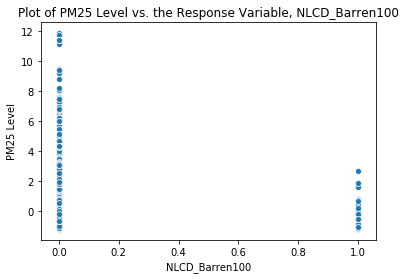

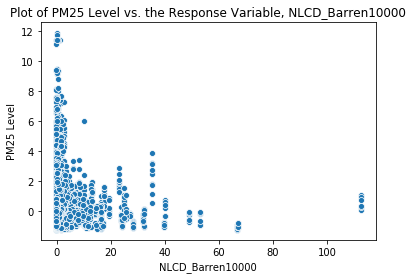

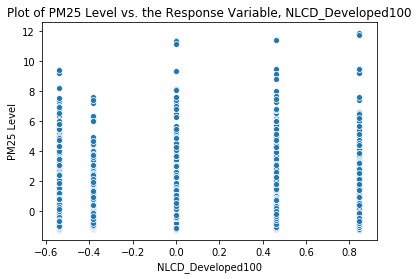

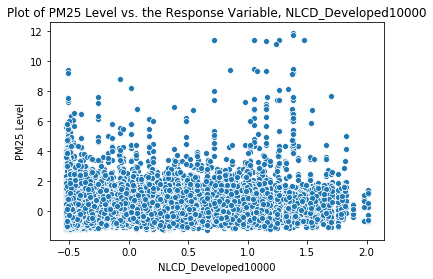

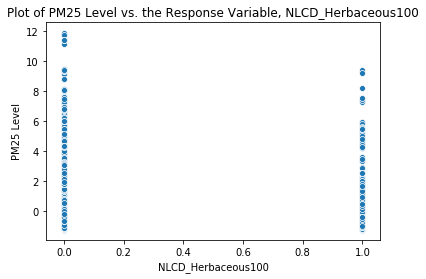

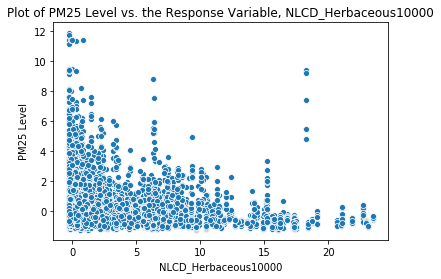

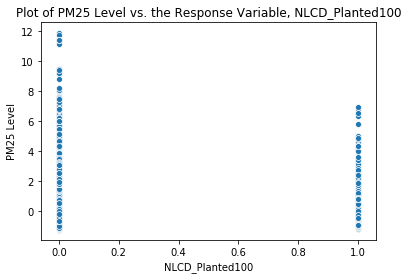

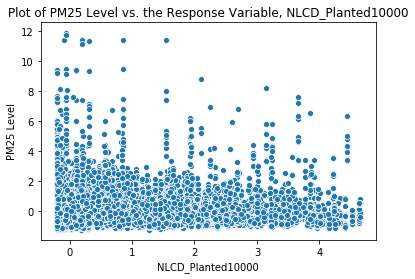

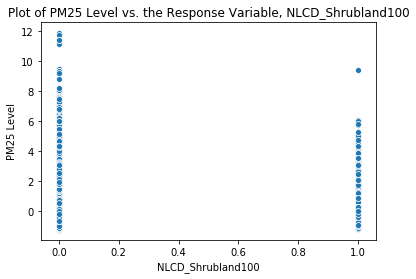

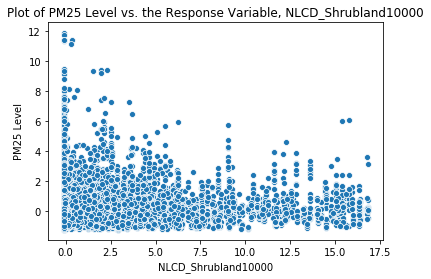

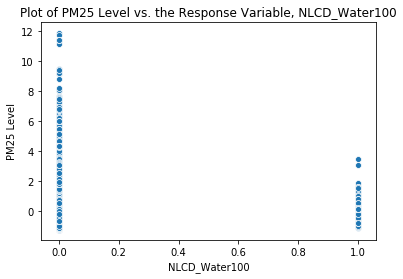

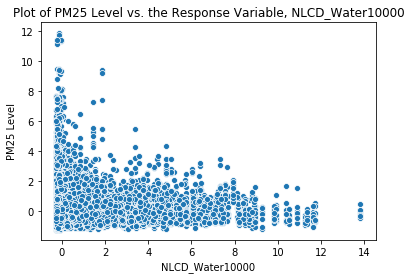

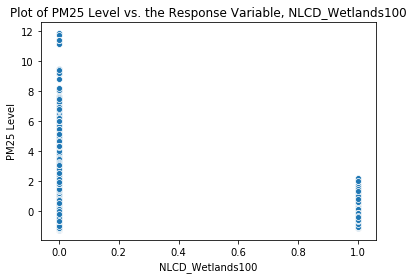

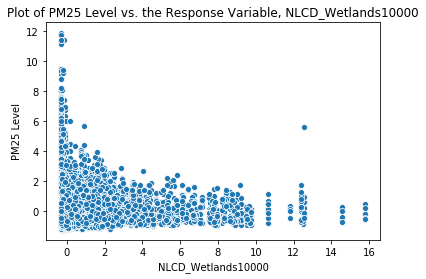

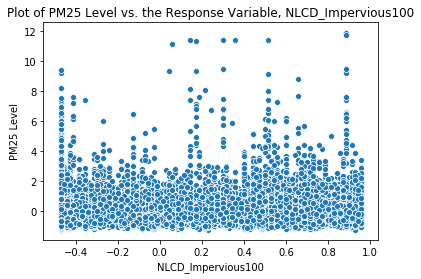

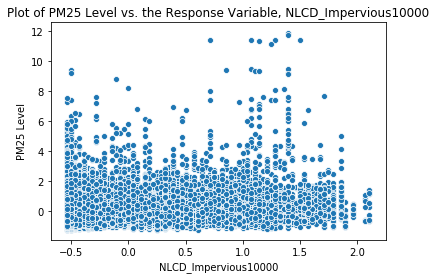

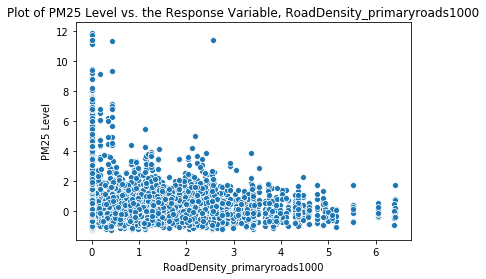

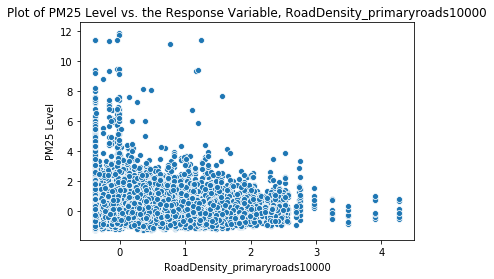

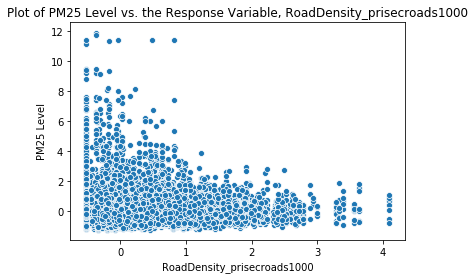

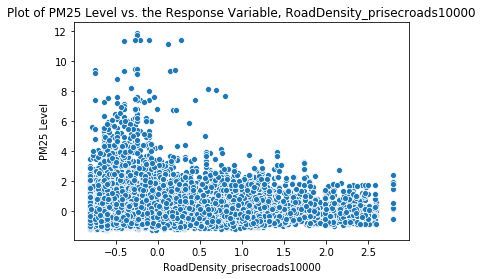

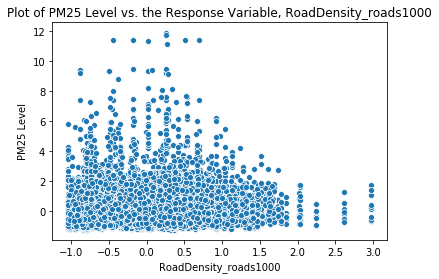

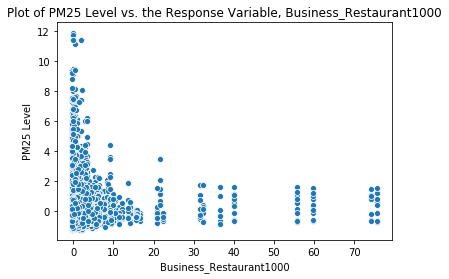

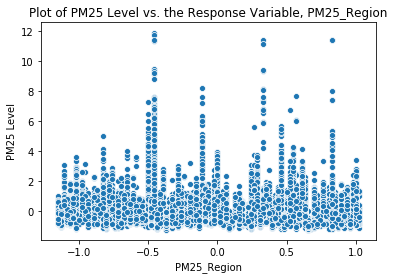

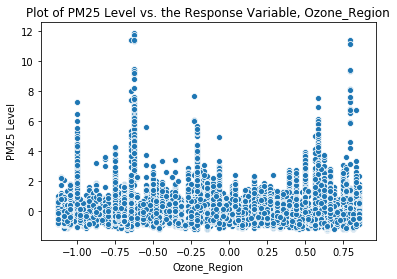

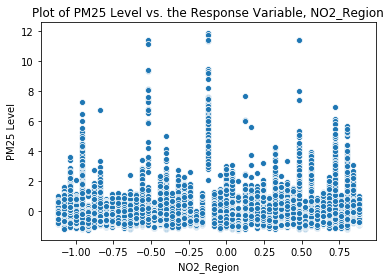

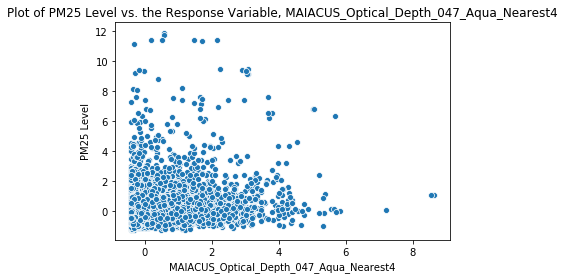

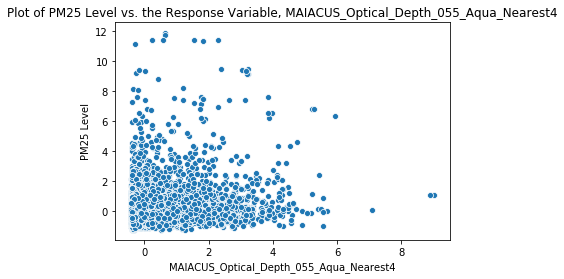

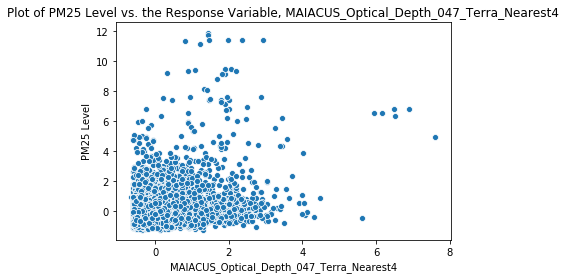

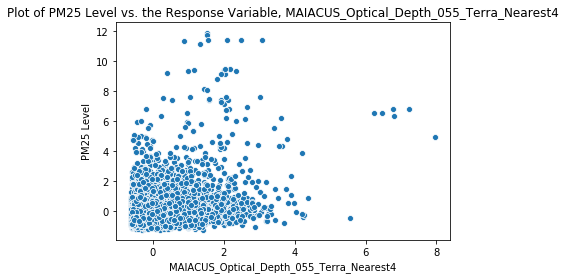

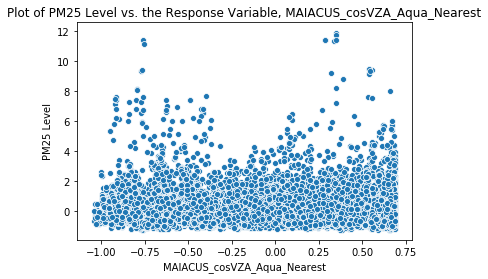

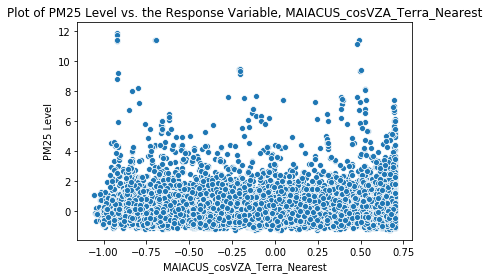

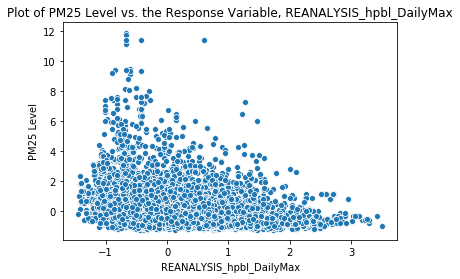

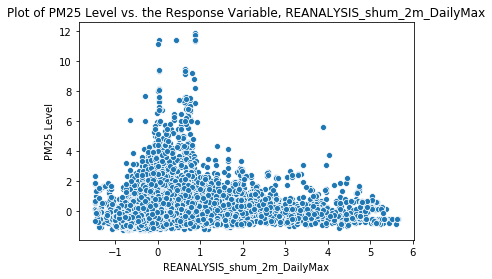

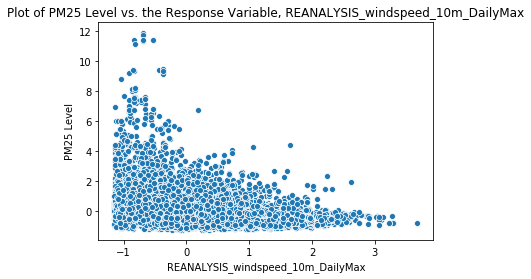

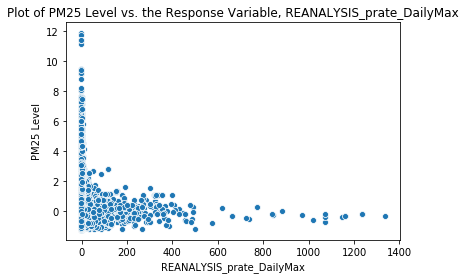

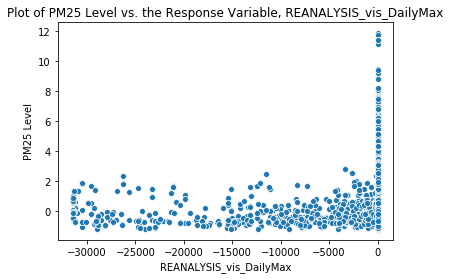

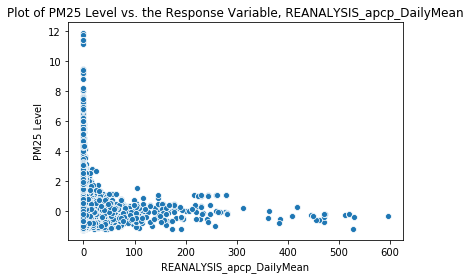

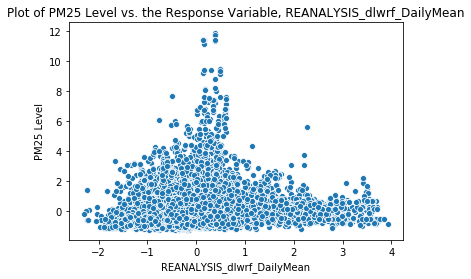

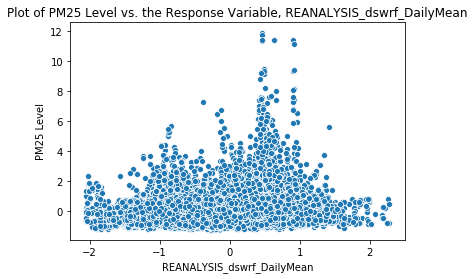

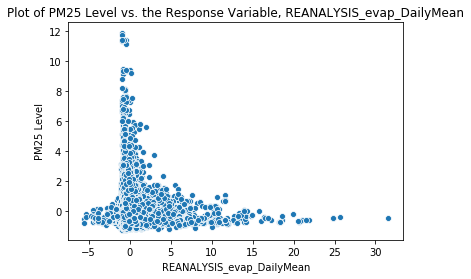

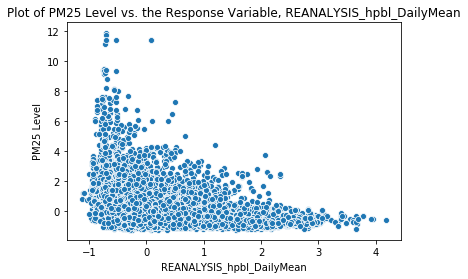

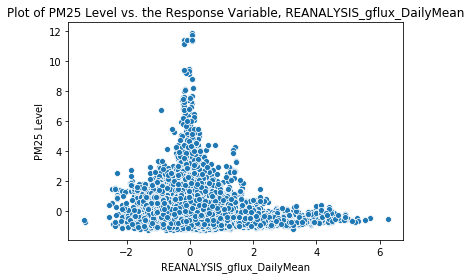

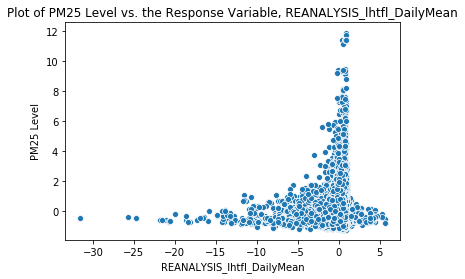

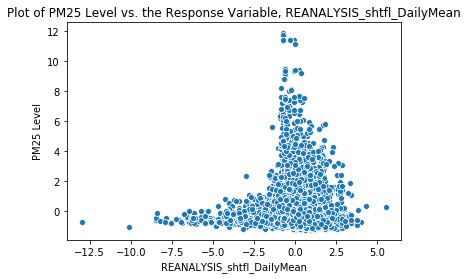

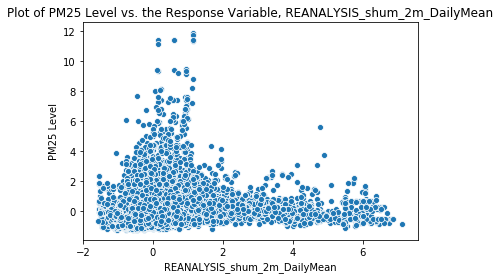

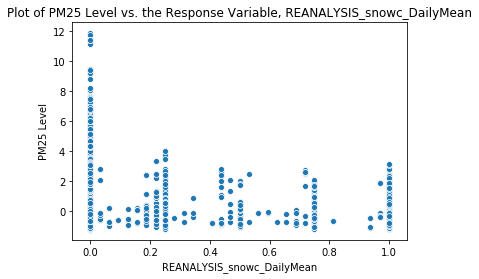

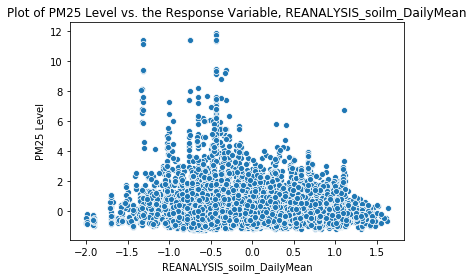

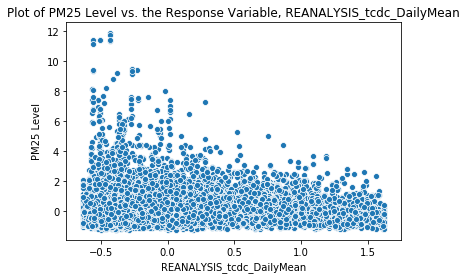

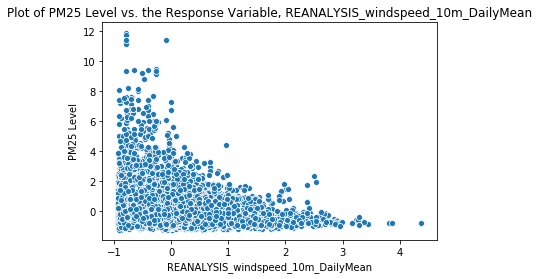

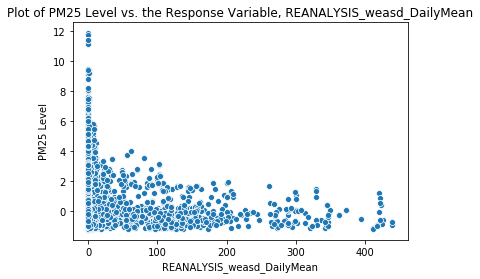

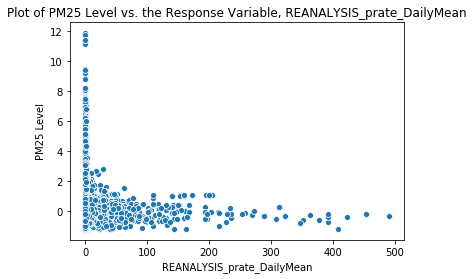

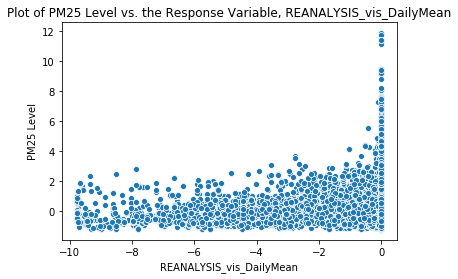

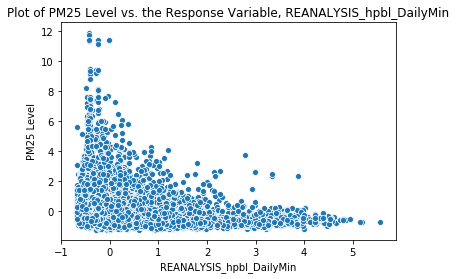

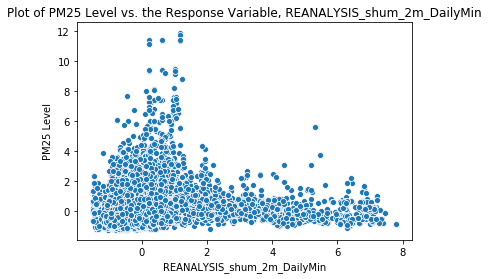

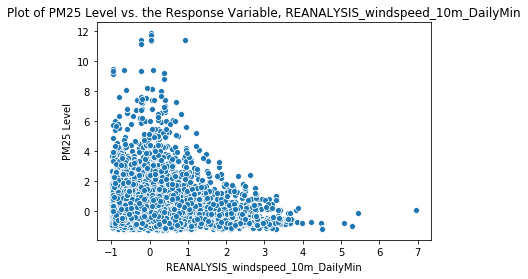

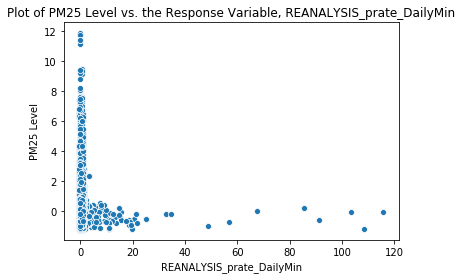

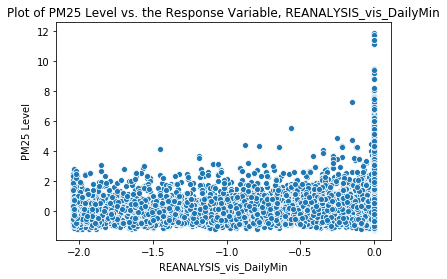

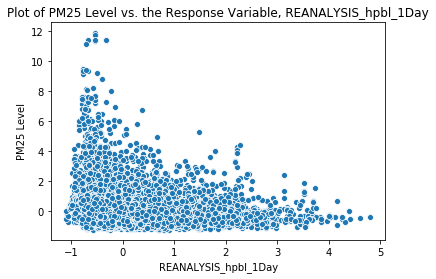

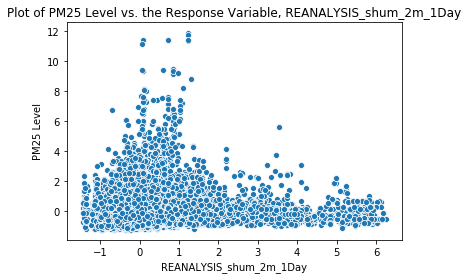

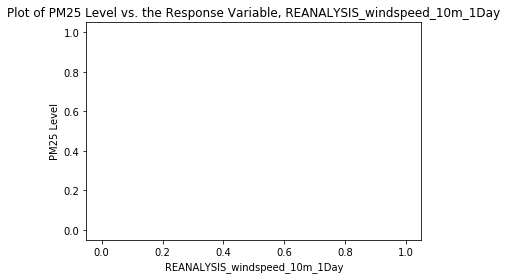

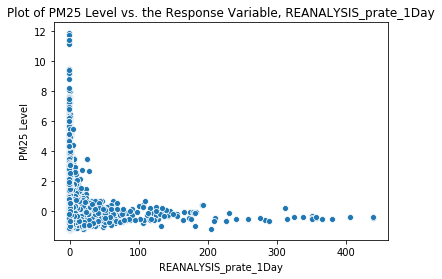

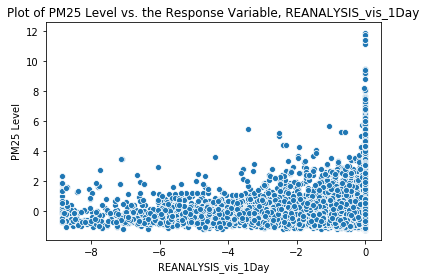

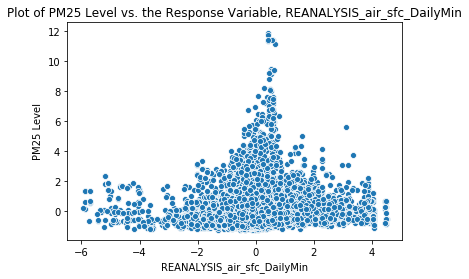

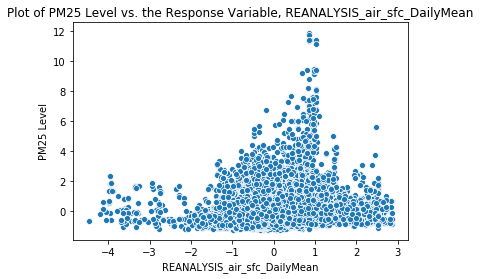

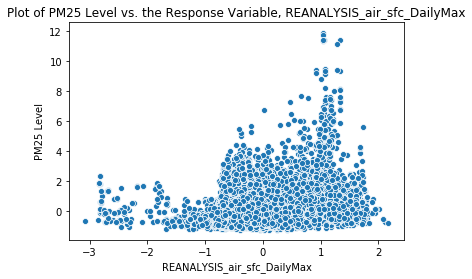

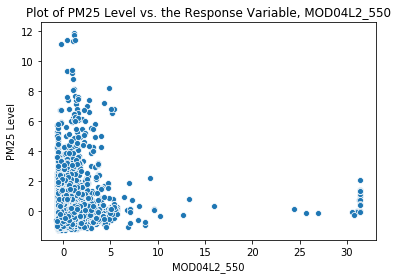

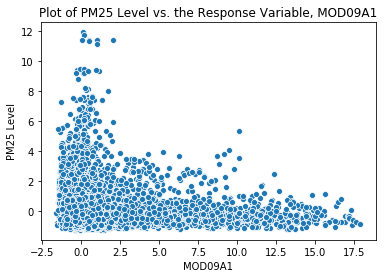

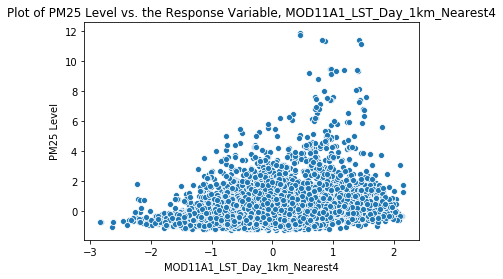

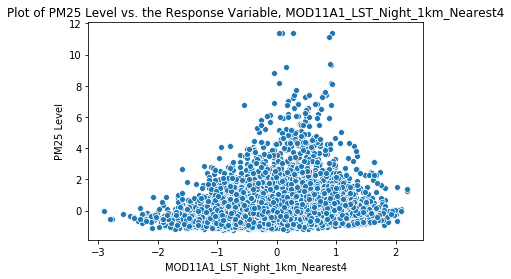

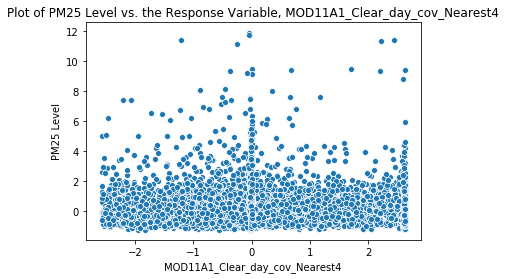

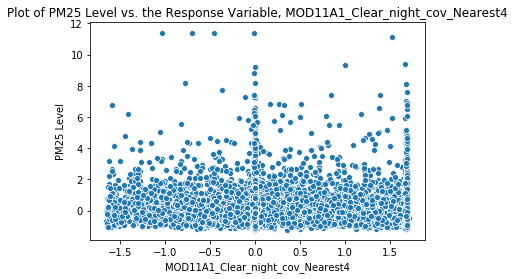

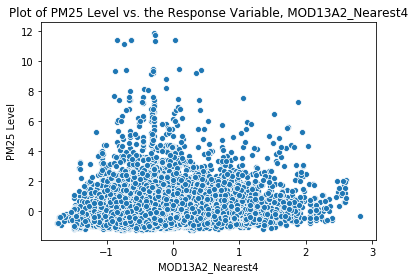

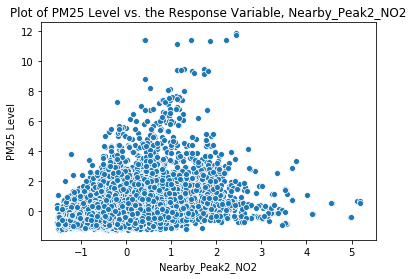

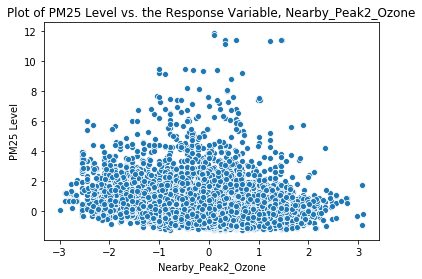

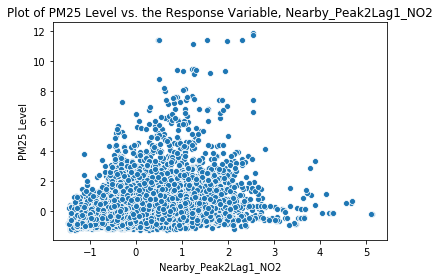

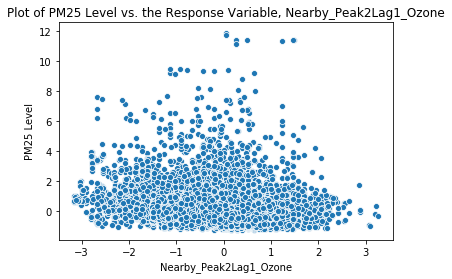

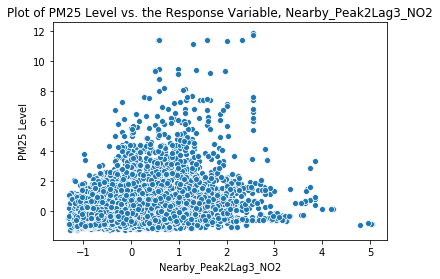

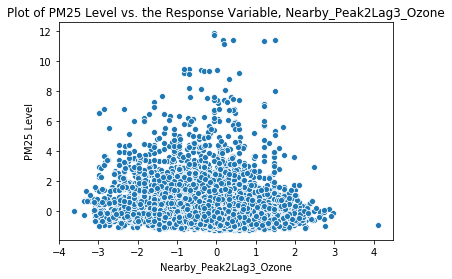

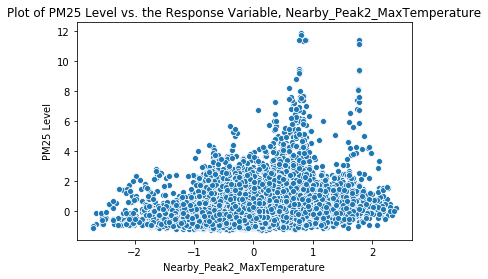

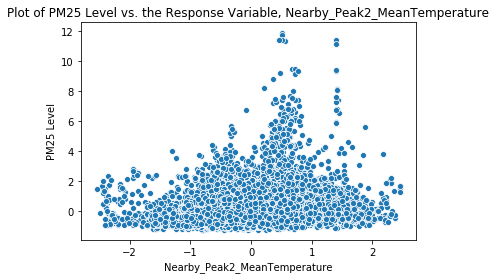

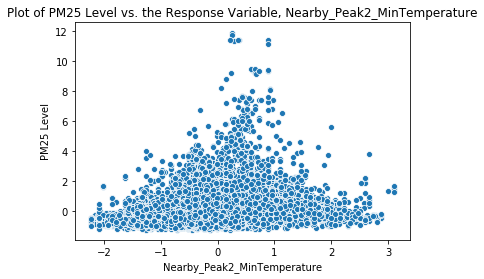

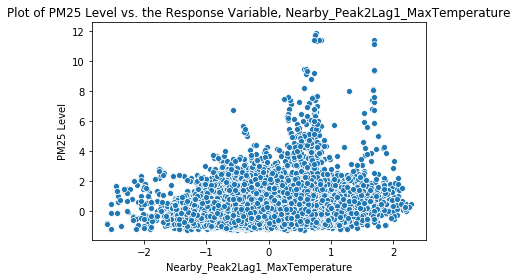

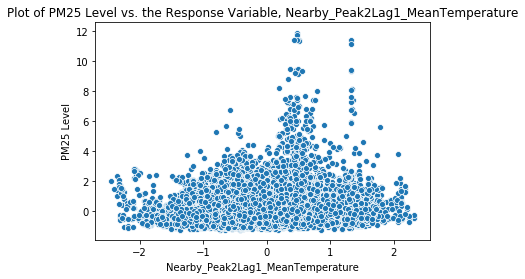

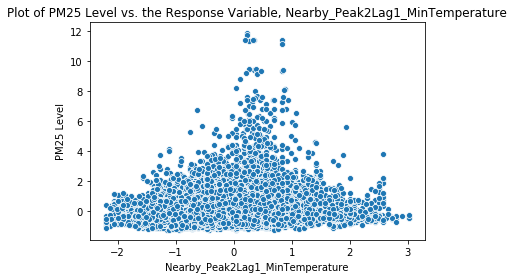

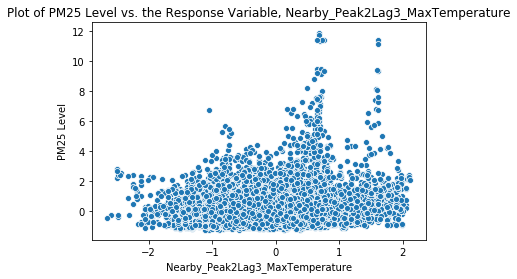

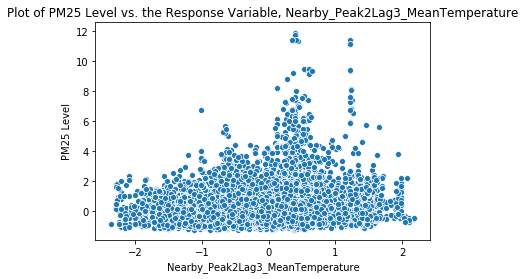

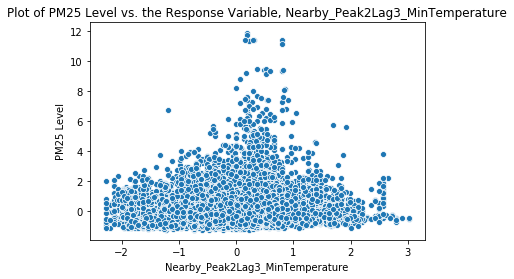

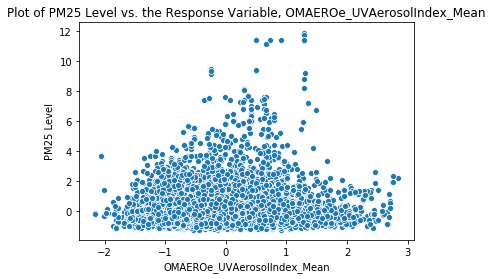

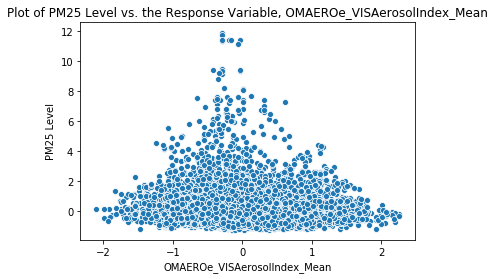

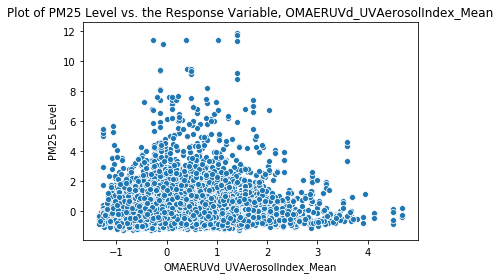

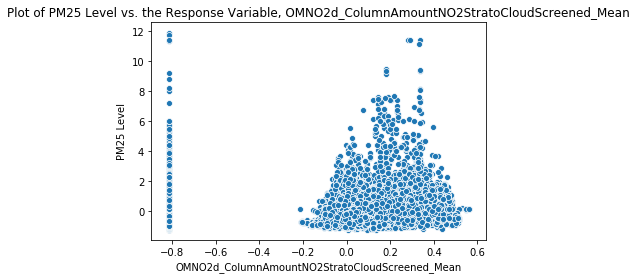

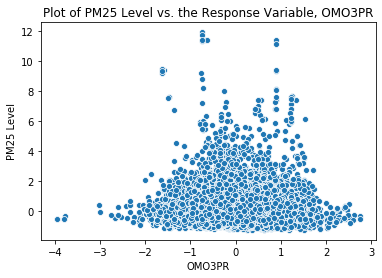

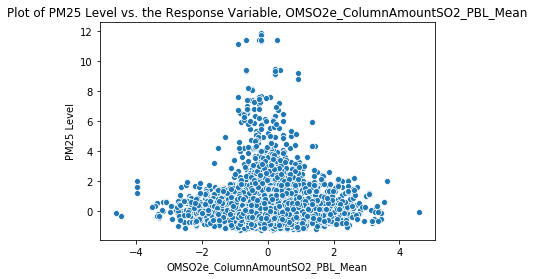

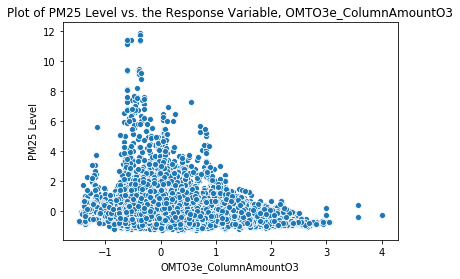

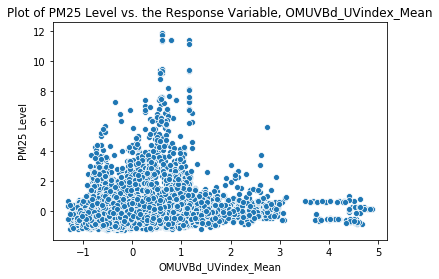

In [236]:
# Glance at the relationships between our predictors and response

for col in X_train.columns:
    ax = sns.scatterplot(x=X_train[col],y=y_train)
    ax.set(title = f"Plot of PM25 Level vs. the Response Variable, {str(col)}", xlabel=str(col), ylabel='PM25 Level')
    plt.show();

### Steps Forward

Moving forward, we'll need to figure out how to gather more data. We'll also want to consider how we might be able to augment the data we already have. There are likely other informative variables out there and we'd love to improve upon the available resources beyond just using them.

We will want to be able to use variables that are available everywhere to accurately predict PM25 measures that are only available locally. We may need to think a bit more about the variables presented here and consider whether or not they will be available throughout the US.

### Bibliography

Sabath, M. Benjamin, et al. "airpred: A Flexible R Package Implementing Methods for Predicting Air Pollution." 2018 IEEE 5th International Conference on Data Science and Advanced Analytics (DSAA). IEEE, 2018.

Di, Qian, et al. "Assessing PM2. 5 exposures with high spatiotemporal resolution across the continental United States." Environmental science & technology 50.9 (2016): 4712-4721.